## Description
This notebook focuses exclusively on manually labelled datasets for testing purposes. Using a BERT model, word embeddings are generated for each individual word in the dataset and compared to the word embeddings of the keyword pool.
The best score in this resulting matrix of each dataset is taken. An iterative process then defines the best threshold based on the f1_score (alternative on the precision, recall or accuracy).

Different scatter plots visualize the resulting similarities, providing insight into why it can be challenging to determine whether a dataset relates to mobility data or not.

In the end the threshold is tested using validationdata.

The code was developed with support from ChatGPT-4.

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Define parameters
model_name = 'google-bert/bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
mobility_keywords_file = 'data/mobility_keywords_pool.txt'
inputdata_file = 'data/03_labelled_data.csv'
outputdata_file = 'data/04_predicted_data_BERT.csv'
validation_file = 'data/06_validationdata.csv'

In [2]:
# Function to convert string into list
def str_to_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

In [3]:
# read csv inputdata_file
df = pd.read_csv(inputdata_file, dtype={'mobilitydata_labelled': 'string'},converters={'combined_DE_keywords': str_to_list}, low_memory=False)

# Drop rows where 'mobilitydata_labelled' is empty (NaN)
df = df.dropna(subset=['mobilitydata_labelled'])

# Convert 'mobilitydata_labelled' to boolean type
df['mobilitydata_labelled'] = df['mobilitydata_labelled'].map({'True': True, 'False': False})

# Print the number of rows remaining after filtering
print(f"Number of labelled rows after filtering: {len(df)}")

Number of labelled rows after filtering: 150


In [4]:
# Inference on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate sentence embeddings (mean pooling)
def get_bert_embeddings(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Load keywords
with open(mobility_keywords_file, 'r', encoding='utf-8') as file:
    mobility_keywords = [line.strip().lower() for line in file if line.strip()]

# Generate vector representations
keyword_embeddings = get_bert_embeddings(mobility_keywords)

In [5]:
def process_entry(word_list):
    # If the field is empty or not a list, return empty results
    if not isinstance(word_list, list):
        return {'words': [], 'similarity_matrix': []}
    
    # Compute embeddings for each word in the list
    embeddings = get_bert_embeddings(word_list)
    similarity_matrix = cosine_similarity(embeddings, keyword_embeddings).tolist()
    
    return {
        'words': word_list,
        'similarity_matrix': similarity_matrix
    }

# Apply to DataFrame column
df[['words', 'similarity_matrix']] = df['combined_DE_keywords'].apply(
    lambda x: pd.Series(process_entry(x))
)

In [6]:
# Function to get the best similarity score
def get_max_similarity(sim_matrix):
    if not sim_matrix or len(sim_matrix) == 0:
        return float('nan')
    
    max_per_word = [max(row) for row in sim_matrix if row]
    if not max_per_word:
        return float('nan')
    
    return max(max_per_word)

In [7]:
# Function to iterate and define the best threshold
def evaluate_threshold(df, threshold):
    # Recalculate max_similarity
    df['max_similarity'] = df['similarity_matrix'].apply(lambda sim_matrix: get_max_similarity(sim_matrix))

    # Recalculate prediction based on threshold
    df['mobilitydata_predicted'] = df['max_similarity'] >= threshold

    # Define categories based on confusion matrix results
    df['confusion_matrix_category'] = 'Unknown'
    df.loc[(df['mobilitydata_labelled'] == True) & (df['mobilitydata_predicted'] == True), 'confusion_matrix_category'] = 'True Positive'
    df.loc[(df['mobilitydata_labelled'] == False) & (df['mobilitydata_predicted'] == False), 'confusion_matrix_category'] = 'True Negative'
    df.loc[(df['mobilitydata_labelled'] == False) & (df['mobilitydata_predicted'] == True), 'confusion_matrix_category'] = 'False Positive'
    df.loc[(df['mobilitydata_labelled'] == True) & (df['mobilitydata_predicted'] == False), 'confusion_matrix_category'] = 'False Negative'

    # Count categories
    counts = df['confusion_matrix_category'].value_counts()
    TP = counts.get('True Positive', 0)
    TN = counts.get('True Negative', 0)
    FP = counts.get('False Positive', 0)
    FN = counts.get('False Negative', 0)

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score  = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
    'threshold': threshold,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'accuracy': accuracy,
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN
}

In [8]:
thresholds = np.arange(0.0, 1.01, 0.01)
results = [evaluate_threshold(df.copy(), t) for t in thresholds]

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find the best threshold based on F1 score
best_row = results_df.loc[results_df['f1_score'].idxmax()]
threshold = best_row['threshold']

# Apply the best threshold to the original DataFrame
evaluate_threshold(df, threshold)

# Update category_counts based on the original DataFrame
category_counts = df['confusion_matrix_category'].value_counts()

print(f"Best threshold based on F1-score: {threshold:.2f}")
print(best_row)

Best threshold based on F1-score: 0.98
threshold      0.980000
precision      0.800000
recall         0.551724
f1_score       0.653061
accuracy       0.886667
TP            16.000000
TN           117.000000
FP             4.000000
FN            13.000000
Name: 98, dtype: float64


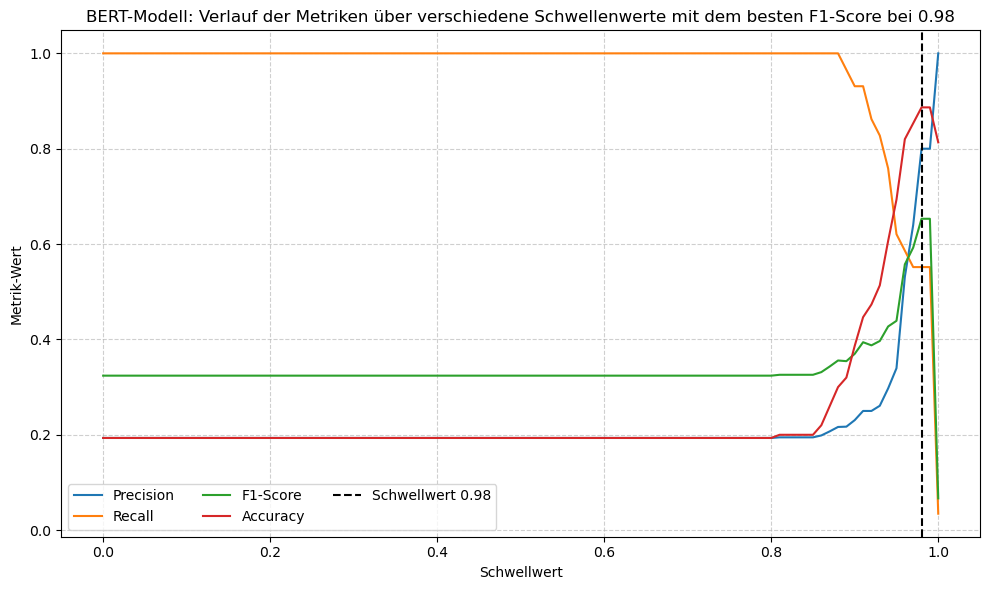

In [9]:
# Plot performance metrics across thresholds
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1_score'], label='F1-Score')
plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
plt.axvline(x=threshold, color='black', linestyle='--', label='Schwellwert 0.98')

plt.xlabel('Schwellwert')
plt.ylabel('Metrik-Wert')
plt.title('BERT-Modell: Verlauf der Metriken über verschiedene Schwellenwerte mit dem besten F1-Score bei 0.98')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol= 3)
plt.tight_layout()
plt.show()

C:\Users\haabs\AppData\Local\Temp\ipykernel_25468\1928615985.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


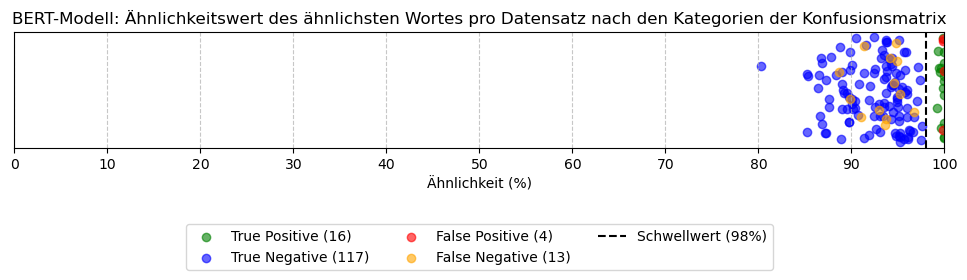

In [10]:
# Define colors for each category
colors = {
    'True Positive': 'green',
    'True Negative': 'blue',
    'False Positive': 'red',
    'False Negative': 'orange'
}

# Create a scatter plot with slight vertical jitter
plt.figure(figsize=(12, 1.5))
for category, color in colors.items():
    subset = df[df['confusion_matrix_category'] == category]
    count = category_counts.get(category, 0)
    x_vals = subset['max_similarity']
    
    # Add small vertical jitter for visibility
    y_jitter = np.random.uniform(-0.05, 0.05, size=len(subset))
    
    plt.scatter(x_vals, y_jitter, color=color, label=f"{category} ({count})", alpha=0.6)

# Plot the threshold line
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Schwellwert ({round(100 * threshold)}%)')

# Custom tick labels as percentages
tick_vals = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tick_labels = [f"{int(x * 100)}" for x in tick_vals]

# Plot formatting
plt.title('BERT-Modell: Ähnlichkeitswert des ähnlichsten Wortes pro Datensatz nach den Kategorien der Konfusionsmatrix')
plt.xlabel('Ähnlichkeit (%)')
plt.xlim(0.7, 1)
plt.yticks([])
plt.xticks(tick_vals, tick_labels)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=3)
plt.tight_layout()
plt.show()

In [11]:
def plot_similarity(df, mobility_keywords, case='worst_fn'):
    """
    Plots the similarity distribution for a specific case:
    case: 'worst_fn' (False Negative with lowest similarity)
          'best_tp'  (True Positive with highest similarity)
    """
    assert case in ['worst_fn', 'best_tp'], "case must be 'worst_fn' or 'best_tp'"

    # Filter by desired category
    if case == 'worst_fn':
        subset = df[df['confusion_matrix_category'] == 'False Negative']
        index = subset['max_similarity'].idxmin()
        title_case = 'worst False Negative'
    elif case == 'best_tp':
        subset = df[df['confusion_matrix_category'] == 'True Positive']
        index = subset['max_similarity'].idxmax()
        title_case = 'best True Positive'

    # Get row data
    row = df.loc[index]
    words = row['words']
    sim_matrix = row['similarity_matrix']

    if not words or not sim_matrix:
        print(f"No content for index {index}")
        return

    num_keywords = len(mobility_keywords)
    num_words = len(words)

    plt.figure(figsize=(12, 6))

    # Define color map for keywords
    colors = plt.cm.get_cmap('tab20', num_keywords)
    sim_matrix_T = list(zip(*sim_matrix))  # Transpose: keywords x words

    # Scatterplot: for each keyword, plot similarity to all words
    for keyword_idx, keyword in enumerate(mobility_keywords):
        similarities = [score * 100 for score in sim_matrix_T[keyword_idx]]
        plt.scatter(range(num_words), similarities, color=colors(keyword_idx), label=keyword)

    # Plot the threshold line
    plt.axhline(y=100*threshold, color='black', linestyle='--', label=f'Schwellwert ({round(100 * threshold)}%)')
    
    # Axes & layout
    plt.xticks(ticks=range(num_words), labels=words, rotation=45, ha='right')
    plt.ylabel("Ähnlichkeit (%)")
    plt.xlabel("Vorprozessierte Keywords")
    plt.title(
        f"BERT-Modell: Mobility-Keyword-Ähnlichkeit pro Wort des \"{title_case}\" (Score {row['max_similarity']:.3f})",
        loc='left'
    )
    plt.ylim(0, 100)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', ncol=2, title="Wörterpool")
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

C:\Users\haabs\AppData\Local\Temp\ipykernel_25468\207251908.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_keywords)


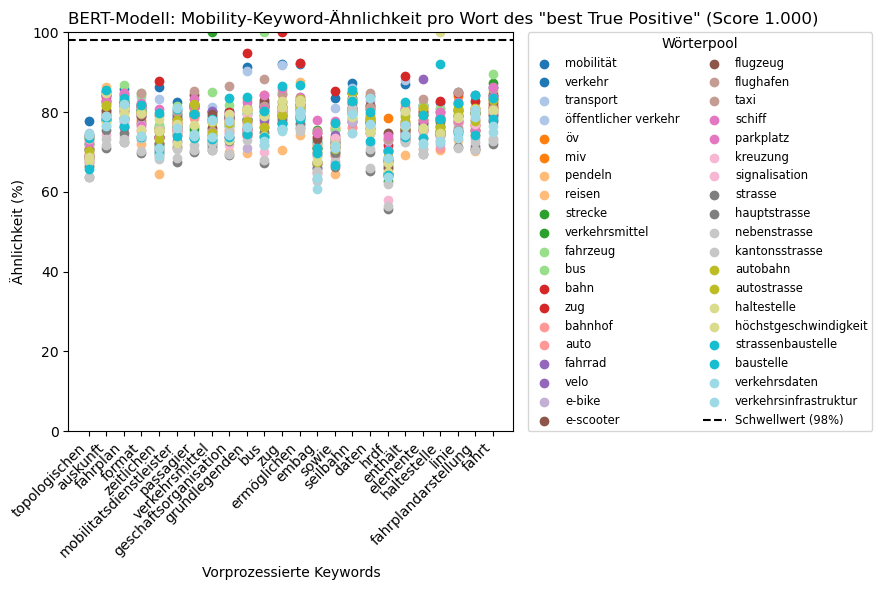

C:\Users\haabs\AppData\Local\Temp\ipykernel_25468\207251908.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_keywords)


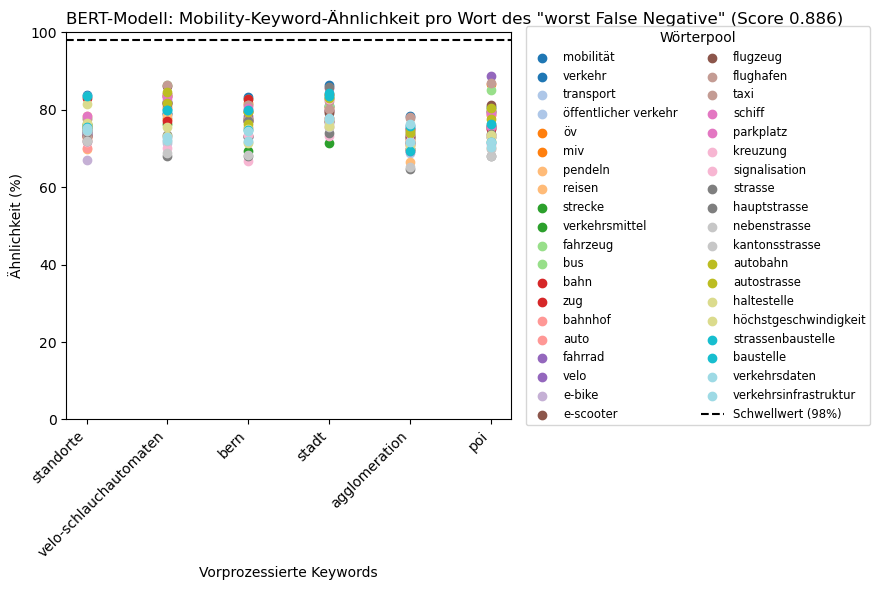

In [12]:
# Plot the best True Positive
plot_similarity(df, mobility_keywords, case='best_tp')

# Plot the worst False Negative
plot_similarity(df, mobility_keywords, case='worst_fn')

In [13]:
# Drop unnecessary columns before saving
columns_to_drop = ['similarity_matrix', 'words']  # columns to remove
df = df.drop(columns=columns_to_drop, errors='ignore')

# Write the DataFrame to a new CSV file
df.to_csv(outputdata_file, index=False)

print(f'The file has been successfully saved as {outputdata_file}.')

The file has been successfully saved as data/04_predicted_data_BERT.csv.


# Validation

In [14]:
df_validation = pd.read_csv(validation_file, dtype={'mobilitydata_labelled': 'string'},converters={'combined_DE_keywords': str_to_list}, low_memory=False)
df_validation = df_validation.dropna(subset=['mobilitydata_labelled'])
df_validation['mobilitydata_labelled'] = df_validation['mobilitydata_labelled'].map({'True': True, 'False': False})
print(f"Number of labelled rows after filtering: {len(df_validation)}")

# Check if there are equal entries in the trainingsdata
overlap_mask = df_validation['dataset_identifier'].isin(df['dataset_identifier'])
print(f"Number of overlapping dataset_identifiers: {overlap_mask.sum()}")
df_duplicates = df_validation[overlap_mask]

Number of labelled rows after filtering: 50
Number of overlapping dataset_identifiers: 0


In [15]:
# Calculate Similarity Matrix
df_validation[['words', 'similarity_matrix']] = df_validation['combined_DE_keywords'].apply(
    lambda x: pd.Series(process_entry(x))
)

In [16]:
fixed_threshold = 0.98

results_validation = evaluate_threshold(df_validation.copy(), fixed_threshold)

for key, value in results_validation.items():
    print(f"{key}: {value}")

threshold: 0.98
precision: 0.6
recall: 0.3333333333333333
f1_score: 0.42857142857142855
accuracy: 0.84
TP: 3
TN: 39
FP: 2
FN: 6


In [17]:
df_validation['max_similarity'] = df_validation['similarity_matrix'].apply(get_max_similarity)

df_validation['mobilitydata_predicted'] = df_validation['max_similarity'] >= 0.98

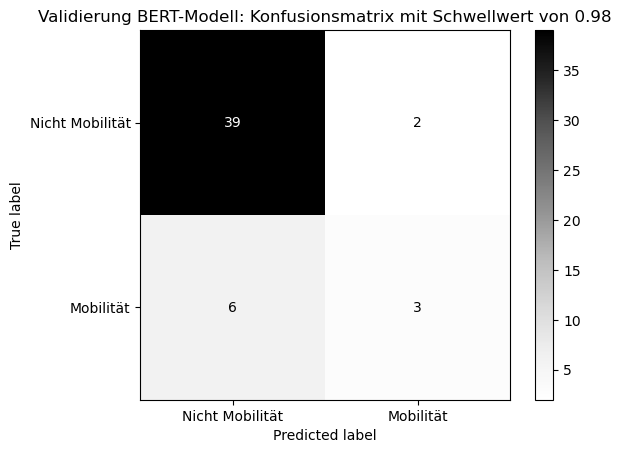

In [18]:
# Generate the confusion matrix using boolean columns
cm = confusion_matrix(df_validation['mobilitydata_labelled'], df_validation['mobilitydata_predicted'])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Nicht Mobilität", "Mobilität"])
disp.plot(cmap=plt.cm.Greys)
plt.title('Validierung BERT-Modell: Konfusionsmatrix mit Schwellwert von 0.98')
plt.show()

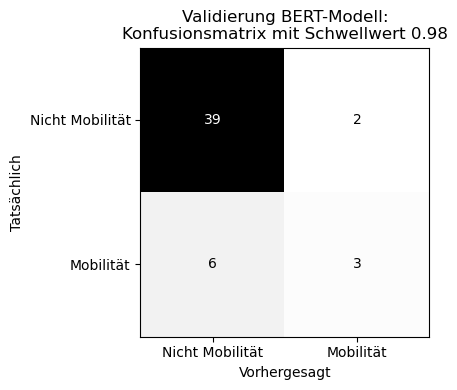

In [ ]:
# Prepare data
y_true = df_validation['mobilitydata_labelled']
y_pred = df_validation['mobilitydata_predicted']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[False, True])

# Set up plot
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Nicht Mobilität", "Mobilität"])
disp.plot(ax=ax, cmap="Greys", colorbar=False)

# Set title and axis labels
ax.set_title("Validierung BERT-Modell:\nKonfusionsmatrix mit Schwellwert 0.98", fontsize=12)
ax.set_xlabel("Vorhergesagt")
ax.set_ylabel("Tatsächlich")

# Layout adjustment and display
plt.tight_layout()
plt.show() 
